In [3]:
# OpenAI Gym
import gym
import gym_tetris
import numpy as np

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


array([[[255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

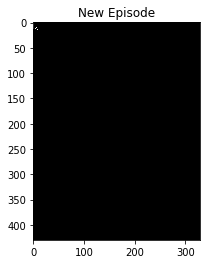

In [5]:

# Load the cart-pole environment
env = gym_tetris.make('Tetris-v0')

# Reinitialize the environment for an episode
observation = env.reset()

# Look at the features the agent will observe during training...
display(observation)

# Render the scene for our visualization purposes...
plt.imshow(env.render(mode='rgb_array'))
plt.title("New Episode") 
plt.show()

In [12]:
# Shape of the observation vectors
display(env.observation_space.shape)

# Number of possible actions
display(env.action_space.n)

(430, 330, 3)

12

(430, 330, 3)


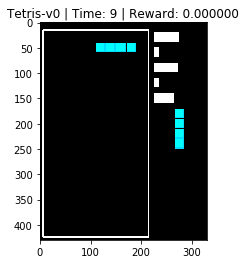

In [7]:
# Initialize the environment and perform 10 random actions
env.reset()
reward = 0.0
for time in range(10):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    observation, reward, done, info = env.step(np.random.choice(env.action_space.n)) # take a random action
    if (done):
        break
clear_output(wait=True)

In [14]:

import keras
import numpy as np

# A simple multilayer architecture....
def make_model(state_size,action_size):
    model = keras.Sequential()
    # Note the input size (there is only one channel - intensity)
    # these images... if you are using color images, your would
    # need to set the last dimension of the input_shape to -3-
    # above and this would carry over into this cell...
    model.add(keras.layers.Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=[state_size.shape[0],
                            state_size.shape[1],
                            state_size.shape[2]]))
    model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001))
    model.summary()
    return model

model = make_model(env.observation_space,env.action_space.n)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 423, 323, 64)      12352     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 416, 316, 128)     524416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 158, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 208, 158, 128)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4206592)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               538443904 
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [15]:
# Turn our observation vector into a matrix of observations
# with only -one- observation and run predict()
Q = model.predict(np.expand_dims(observation,axis=0))
Q

array([[ -9.047846 , -19.131031 ,  -5.4079876,  -6.9576344,  -6.495033 ,
         30.443184 ,  17.144133 ,  14.115261 ,   6.3962865, -13.115321 ,
         26.88964  ,  13.522521 ]], dtype=float32)

In [16]:
np.argmax(Q)

5

In [17]:
# Example e-soft policy...
epsilon = 0.5 # Half of the time, a random action is chosen...
action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
action

5

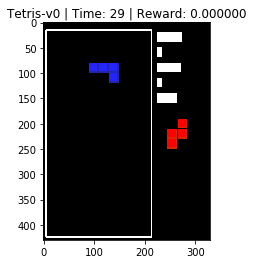

In [18]:
# Initialize the environment and let the agent decide!
observation = env.reset()
epsilon = 0.0 # No exploration!
reward = 0.0
for time in range(30):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)

In [19]:

# Step 1 - Replay Memory Class
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.done = [False]*memory_size # Boolean (terminal transition?)

    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            
            # Obtain model's current Q-values
            model_targets = model.predict(current_state)
            
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model.predict(next_state),axis=1)
            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets
            
            # Update the weights accordingly
            model.fit(current_state,model_targets,
                     epochs=1,verbose=0,batch_size=sample_size)
            
        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [22]:
# Full setup for the task...

# For keeping track of performance
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.01
episodes = 1000

replay_iterations = 100
replay_sample_size = 256

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym_tetris.make('Tetris-v0')
model = make_model(env.observation_space,env.action_space.n)
target_model = make_model(env.observation_space,env.action_space.n)
memory = ReplayMemory(10000,env.observation_space,env.action_space.n)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 423, 323, 64)      12352     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 416, 316, 128)     524416    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 208, 158, 128)     0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 208, 158, 128)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4206592)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               538443904 
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [23]:
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    for time in range(500):
        Q = model.predict(np.expand_dims(current_state,axis=0)) # Compute Q
        action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        if done:
            reward = -10.0
        memory.remember(current_state,action,reward,next_state,done) # Store in memory...
        current_state = next_state # Transition to next state!
        if (done):
            break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f'%(episode+1,episodes,time,mean_time,epsilon),end='')
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

error: display Surface quit

In [ ]:
# Plot results
plt.plot(mean_times)
plt.title("Cart-pole Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Average # Steps [N=100]")
plt.show()

In [ ]:

# Test out the agent!
# Initialize the environment and let the agent decide how to act!
observation = env.reset()
for time in range(50):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.argmax(Q)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)